>📘 Learning Objectives
>
> 1. How to crop a single data file
> 2. How to create a data cube with `xarray`
> 3. Extract variables, temporal slices, and spatial slices from an `xarray` dataset 
> 4. Plot data and exclude data points via boolean conditions, using `xarray`, `cartopy`, and `matplotlib`

## Summary

In this examples we will use the [xarray](https://xarray.dev/) and [earthaccess](https://nsidc.github.io/earthaccess/) to subset data and make figures.

### Import Required Packages

In [13]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
from pprint import pprint

import earthaccess
import xarray as xr
xr.set_options(display_expand_attrs=False)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline

## Authenticate to NASA Earthdata

We will authenticate our Earthaccess session, and then open the results like we did in the Search & Discovery section.

In [15]:
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

## Get a vector of urls to our nc files

In [16]:
short_name = 'MUR-JPL-L4-GLOB-v4.1'
version = "4.1"
date_start = "2020-01-16"
date_end = "2020-12-16"
date_range = (date_start, date_end)
# min lon, min lat, max lon, max lat
bbox = (-75.5, 33.5, -73.5, 35.5)  

# For reference (e.g., to visualize in https://geojson.io/), here is a GeoJSON representing the above bounding box:
# {"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {}, "geometry": {"type": "LineString", "bbox": [-127.0761, 31.6444, -113.9039, 42.631], "coordinates": [[-113.9039, 42.631], [-127.0761,42.631], [-127.0761, 31.6444], [-113.9039, 31.6444], [-113.9039, 42.631]]}}]}

results = earthaccess.search_data(
    short_name = short_name,
    version = version,
    cloud_hosted = True,
    temporal = date_range,
    bounding_box = bbox,
)

Granules found: 336


## Crop and plot one netCDF file

Each MUR SST `netCDF` file is large so I do not want to download. Instead we will subset the data on the server side. We will start with one file.



In [31]:
fileset = earthaccess.open(results[0:1])
ds = xr.open_dataset(fileset[0])

Opening 336 granules, approx size: 231.79 GB


QUEUEING TASKS | :   0%|          | 0/336 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/336 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/336 [00:00<?, ?it/s]

Note that `xarray` works with "lazy" computation whenever possible. In this case, the metadata are loaded into JupyterHub memory, but the data arrays and their values are not — until there is a need for them.

Let's print out all the variable names.

In [24]:
for v in ds.variables:
    print(v)

time
lat
lon
analysed_sst
analysis_error
mask
sea_ice_fraction
dt_1km_data
sst_anomaly


Of the variables listed above, we are interested in `analysed_sst`.

In [25]:
ds.variables['analysed_sst'].attrs

{'long_name': 'analysed sea surface temperature',
 'standard_name': 'sea_surface_foundation_temperature',
 'units': 'kelvin',
 'valid_min': -32767,
 'valid_max': 32767,
 'comment': '"Final" version using Multi-Resolution Variational Analysis (MRVA) method for interpolation',
 'source': 'MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTA_G-NAVO, AVHRRMTB_G-NAVO, iQUAM-NOAA/NESDIS, Ice_Conc-OSISAF'}

### Subsetting

In addition to directly accessing the files archived and distributed by each of the NASA DAACs, many datasets also support services that allow us to customize the data via subsetting, reformatting, reprojection/regridding, and file aggregation. What does subsetting mean? To **subset** means to extract only the portions of a dataset that are needed for a given purpose. 

There are three primary types of subsetting that we will walk through: 
1. Temporal
2. Spatial
3. Variable

In each case, we will be excluding parts of the dataset that are not wanted using `xarray`. Note that "subsetting" is also called a data "transformation".

In [27]:
ds.lon.values

array([-179.99, -179.98, -179.97, ...,  179.98,  179.99,  180.  ],
      dtype=float32)

In [28]:
# Display the full dataset's metadata
ds

<xarray.Dataset> Size: 29GB
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 8B 2020-01-16T09:00:00
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 5GB ...
    analysis_error    (time, lat, lon) float64 5GB ...
    mask              (time, lat, lon) float32 3GB ...
    sea_ice_fraction  (time, lat, lon) float64 5GB ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] 5GB ...
    sst_anomaly       (time, lat, lon) float64 5GB ...
Attributes: (47)

Now we will prepare a subset. We're using essentially the same spatial bounds as above; however, as opposed to the `earthaccess` inputs above, here we must provide inputs in the formats expected by `xarray`. Instead of a single, four-element, bounding box, we use Python `slice` objects, which are defined by starting and ending numbers.

In [29]:
ds_subset = ds.sel(time=date_start, lat=slice(33.5, 35.5), lon=slice(-75.5, -73.5)) 
ds_subset

<xarray.Dataset> Size: 2MB
Dimensions:           (time: 1, lat: 201, lon: 201)
Coordinates:
  * time              (time) datetime64[ns] 8B 2020-01-16T09:00:00
  * lat               (lat) float32 804B 33.5 33.51 33.52 ... 35.48 35.49 35.5
  * lon               (lon) float32 804B -75.5 -75.49 -75.48 ... -73.51 -73.5
Data variables:
    analysed_sst      (time, lat, lon) float64 323kB ...
    analysis_error    (time, lat, lon) float64 323kB ...
    mask              (time, lat, lon) float32 162kB ...
    sea_ice_fraction  (time, lat, lon) float64 323kB ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] 323kB ...
    sst_anomaly       (time, lat, lon) float64 323kB ...
Attributes: (47)

### Plotting

We will first plot using the methods built-in to the `xarray` package.

Note that, as opposed to the "lazy" loading of metadata previously, this will now perform "eager" computation, pulling the required data chunks.

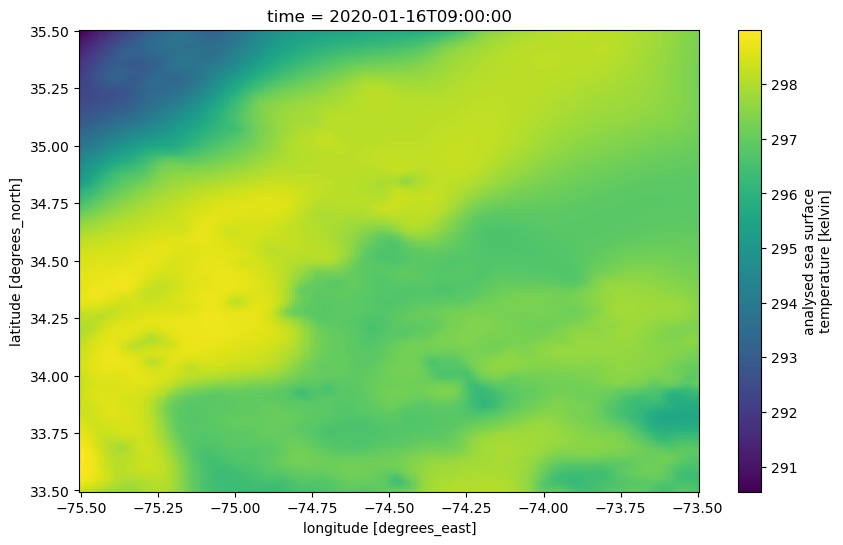

In [30]:
ds_subset['analysed_sst'].plot(figsize=(10,6), x='lon', y='lat');

## Crop and plot multiple netCDF files

When we open multiple files, we use `open_mfdataset()`. Once again, we are doing lazy loading.

In [55]:
fileset = earthaccess.open(results[0:4])
ds = xr.open_mfdataset(fileset)

Opening 4 granules, approx size: 2.65 GB


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

We can subset as we did with a single file.

In [41]:
ds_subset = ds.sel(lat=slice(33.5, 35.5), lon=slice(-75.5, -73.5)) 
ds_subset

<xarray.Dataset> Size: 7MB
Dimensions:           (time: 4, lat: 201, lon: 201)
Coordinates:
  * time              (time) datetime64[ns] 32B 2020-01-16T09:00:00 ... 2020-...
  * lat               (lat) float32 804B 33.5 33.51 33.52 ... 35.48 35.49 35.5
  * lon               (lon) float32 804B -75.5 -75.49 -75.48 ... -73.51 -73.5
Data variables:
    analysed_sst      (time, lat, lon) float64 1MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 1MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    mask              (time, lat, lon) float32 646kB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 1MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] 1MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float64 1MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
Attributes: (47)

Now we can plot the 4 days of data.

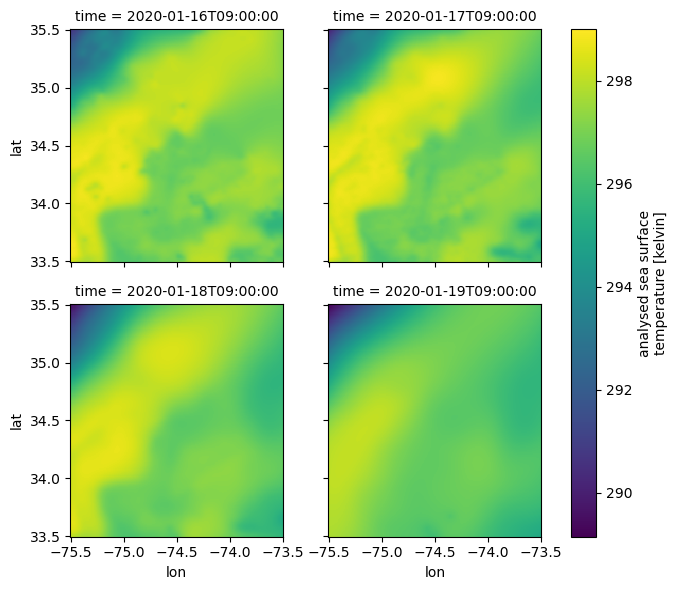

In [43]:
ds_subset['analysed_sst'].plot(x='lon', y='lat', col="time", col_wrap=2);

In the following plotting commands, we utilize `cartopy` and `matplotlib` to generate a more customized figure. 

`cartopy` is used to set the map projection (to PlateCarree) and to add U.S. state boundary lines to the figure. `matplotlib`'s pcolormesh is used to generate the color plot, with colors determined by the third argument's value.

In [56]:
ds_one = ds.sel(time = date_start, lat=slice(30, 40), lon=slice(-85.5, -63.5))
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)


In [58]:
#ds_one['analysed_sst'].plot(x='lon', y='lat')
p = ds_one['analysed_sst'].plot(transform=ccrs.PlateCarree(),  
             aspect=ds.dims['lon'] / ds.dims['lat'],  # for a sensible figsize
             subplot_kws={'projection': map_proj})  # the plot's projection

ValueError: cannot provide `aspect` argument without `size`

ValueError: 'box-forced' is not a valid value for adjustable; supported values are 'box', 'datalim'

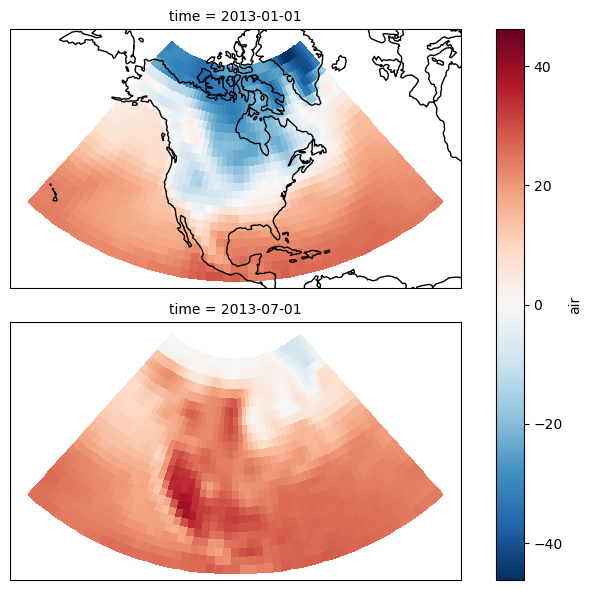

In [52]:
from __future__ import division

import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Load the data
ds = xr.tutorial.load_dataset('air_temperature')
air = ds.air.isel(time=[0, 724]) - 273.15

# This is the map projection we want to plot *onto*
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)

p = air.plot(transform=ccrs.PlateCarree(),  # the data's projection
             col='time', col_wrap=1,  # multiplot settings
             aspect=ds.dims['lon'] / ds.dims['lat'],  # for a sensible figsize
             subplot_kws={'projection': map_proj})  # the plot's projection

# We have to set the map's options on all four axes
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent([-160, -30, 5, 75])
    # Without this aspect attributes the maps will look chaotic and the
    # "extent" attribute above will be ignored
    ax.set_aspect('equal', 'box-forced')

plt.show()

Notice the enhancements?

Also, note that you can explore these (and other) data before generating your own customized plots, by using NASA Worldview. [Here's a link](https://worldview.earthdata.nasa.gov/?v=-156.13974252713064,12.501303538340089,-58.87926564851792,62.28255353834009&l=Reference_Labels_15m(hidden),Reference_Features_15m(hidden),Coastlines_15m,IMERG_Precipitation_Rate,VIIRS_NOAA20_CorrectedReflectance_TrueColor(hidden),VIIRS_SNPP_CorrectedReflectance_TrueColor(hidden),MODIS_Aqua_CorrectedReflectance_TrueColor(hidden),MODIS_Terra_CorrectedReflectance_TrueColor(hidden)&lg=true&t=2023-02-24-T10%3A00%3A00Z) to an example map on Worldview for these IMERG data.

END of Notebook.